# Classify Electrocardiograms (ECG)

In [20]:
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, Input, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

## (1) The ECG Dataset

### (1.1) Loading the dataset

In [3]:
# Loading X
response = requests.get('https://wagon-public-datasets.s3.amazonaws.com/06-DL/ECG_X.npy')
response.raise_for_status()
X = np.load(io.BytesIO(response.content), allow_pickle=True).tolist()

# Loading y
response = requests.get('https://wagon-public-datasets.s3.amazonaws.com/06-DL/ECG_y.npy')
response.raise_for_status()
y = np.load(io.BytesIO(response.content), allow_pickle=True).tolist()

### (1.2) Visualizing some ECGs

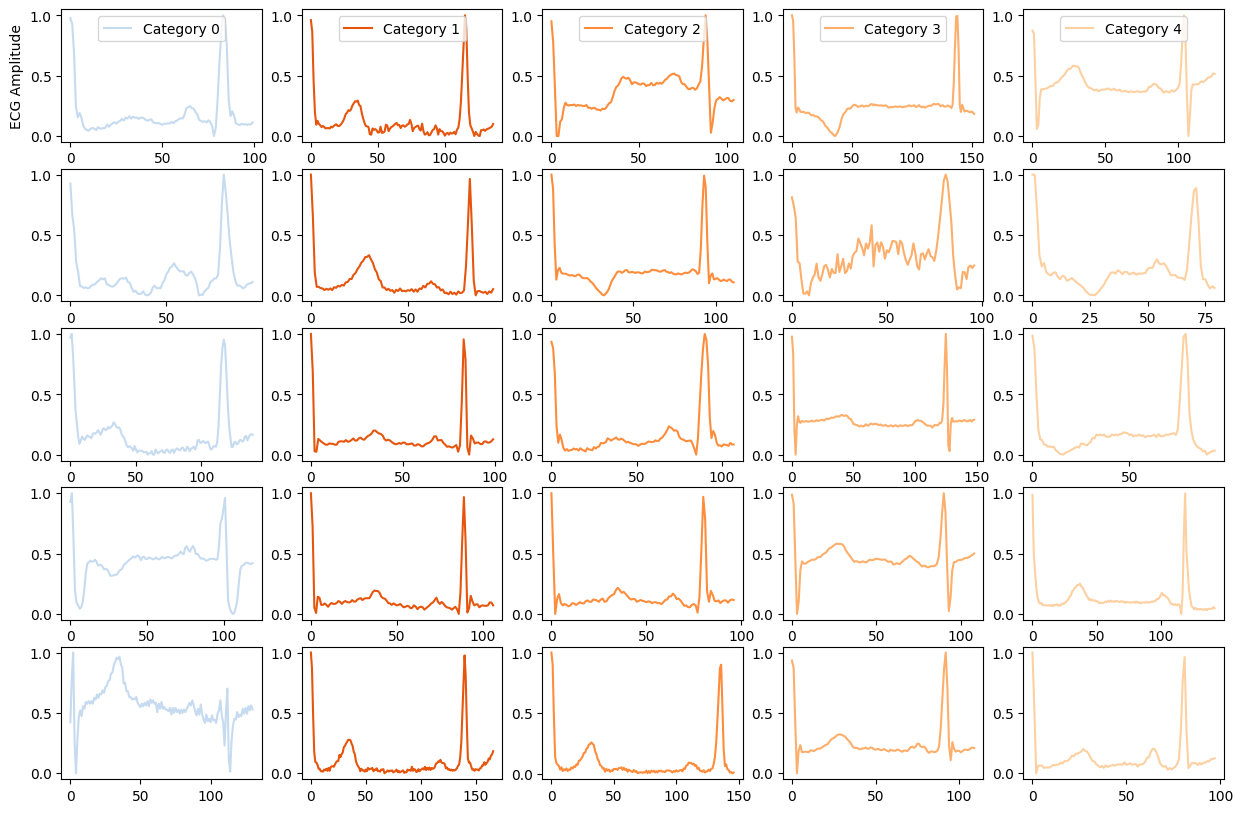

In [5]:
cmap = plt.get_cmap("tab20c")
colors_list = cmap.colors

fix, axs = plt.subplots(5,5, figsize=(15,10))

for i in range(5): # Five examples per category
    for j in range(5): # Iterating over the 5 categories
        idx_C = np.argwhere(np.array(y) == j)  # Collecting the indexes of all the heartbeats of category j
        axs[i,j].plot(X[idx_C[i][0]], label=f'Category {j}', c=colors_list[j+3]) # Plotting the ECG
        # Some cosmetic tricks down below
        if i == 0:
            axs[i,j].legend(loc='upper center')
            if j ==0:
                axs[i,j].set_xlabel('Time')
                axs[i,j].set_ylabel('ECG Amplitude')

### (1.3) Padding the sequences

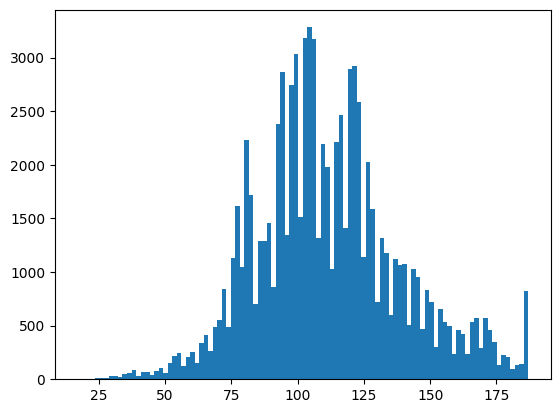

In [6]:
plt.hist([len(_) for _ in X], bins=100)
plt.show()

In [8]:
X_pad = pad_sequences(X, dtype='float32', padding='post', value=-1)
X_pad[0]

array([ 0.97794116,  0.9264706 ,  0.6813725 ,  0.24509804,  0.15441176,
        0.19117647,  0.15196079,  0.08578432,  0.05882353,  0.04901961,
        0.04411765,  0.06127451,  0.06617647,  0.06127451,  0.04901961,
        0.07352941,  0.06127451,  0.06127451,  0.06617647,  0.06862745,
        0.09558824,  0.0759804 ,  0.09313726,  0.10539216,  0.11519608,
        0.10294118,  0.11764706,  0.125     ,  0.14215687,  0.12745099,
        0.15196079,  0.14460784,  0.16421568,  0.14460784,  0.15931372,
        0.15196079,  0.15441176,  0.14215687,  0.15196079,  0.15196079,
        0.14705883,  0.13235295,  0.12745099,  0.13480392,  0.13725491,
        0.1127451 ,  0.10784314,  0.10539216,  0.10784314,  0.09803922,
        0.09313726,  0.10294118,  0.1004902 ,  0.10539216,  0.10294118,
        0.11764706,  0.10539216,  0.12254902,  0.12745099,  0.14215687,
        0.14705883,  0.14460784,  0.1740196 ,  0.23039216,  0.23774509,
        0.24754901,  0.23039216,  0.2254902 ,  0.1985294 ,  0.17

In [9]:
X_pad.shape

(87554, 187)

In [10]:
X_pad = np.expand_dims(X_pad, -1)

### (1.4) Encoding the categorical targets

In [12]:
y_cat = to_categorical(y)
y_cat.shape

(87554, 5)

## (2) RNN modeling

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, train_size=0.8)

### (2.1) GRU and LSTM

In [16]:
model = Sequential()

model.add(Input(shape=(187,1)))

model.add(layers.Masking(mask_value=-1.))

model.add(layers.GRU(units=20, activation='tanh', return_sequences=True))
model.add(layers.GRU(units=20, activation='tanh', return_sequences=False))

model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 187, 20)        │         1,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 20)             │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         1,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,205 (20.33 KB)

 Trainable params: 5,205 (20.33 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
es = EarlyStopping(patience=2)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=75,
          batch_size=256,
          verbose=1,
          callbacks = [es],
          validation_split=0.2)

Epoch 1/75
219/219 ━━━━━━━━━━━━━━━━━━━━ 47s 193ms/step - accuracy: 0.8228 - loss: 0.7384 - val_accuracy: 0.8329 - val_loss: 0.6437
Epoch 2/75
219/219 ━━━━━━━━━━━━━━━━━━━━ 43s 196ms/step - accuracy: 0.8263 - loss: 0.6747 - val_accuracy: 0.8329 - val_loss: 0.6430
Epoch 3/75
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 174ms/step - accuracy: 0.8263 - loss: 0.6733 - val_accuracy: 0.8329 - val_loss: 0.6436
Epoch 4/75
219/219 ━━━━━━━━━━━━━━━━━━━━ 38s 172ms/step - accuracy: 0.8263 - loss: 0.6726 - val_accuracy: 0.8329 - val_loss: 0.6485


In [21]:
model.evaluate(X_test, y_test)

548/548 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8281 - loss: 0.6618


[0.6617633104324341, 0.8280509114265442]

## (3) Baseline Model

In [22]:
# As a reminder, here is y_train "encoded"
y_train

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], shape=(70043, 5))

In [23]:
# Let's compute the occurencies per heartbeat category in the train set
occurencies_per_heartbeat_category_train = np.sum(y_train, axis=0)
occurencies_per_heartbeat_category_train

array([57971.,  1756.,  4643.,   515.,  5158.])

In [24]:
# You can see that the first category is the most frequent one in the train set
most_frequent_category_train = np.argmax(occurencies_per_heartbeat_category_train)
most_frequent_category_train

np.int64(0)

In [25]:
# We can compute the occurencies per heartbeat category in the test set as well
occurencies_per_heartbeat_category_test = np.sum(y_test, axis=0)
occurencies_per_heartbeat_category_test

array([14500.,   467.,  1145.,   126.,  1273.])

In [26]:
# Let's predict the most_frequent_category_train category for all the ECG in the test set
number_of_correct_predictions = occurencies_per_heartbeat_category_test[most_frequent_category_train]
number_of_correct_predictions

np.float64(14500.0)

In [27]:
# "Evaluating" the baseline model: in the test set, a baseline model will always predict
# the most frequent class found in the train set
baseline_accuracy = number_of_correct_predictions/len(y_test)
print(f'Baseline accuracy = {round(baseline_accuracy,3)}')

Baseline accuracy = 0.828


In [28]:
y_pred = model.predict(X_test)
y_pred.shape

548/548 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step


(17511, 5)

In [29]:
# Distribution of the predictions
pd.DataFrame(y_pred).mean().sort_values(ascending=False)

0    0.791992
4    0.086741
2    0.077072
1    0.032985
3    0.011206
dtype: float32

In [30]:
# Distribution of the real values y_train
pd.DataFrame(y_train).mean().sort_values(ascending=False)

0    0.827649
4    0.073640
2    0.066288
1    0.025070
3    0.007353
dtype: float64